# This project is a simple application of graph theory in finance. In it we first try to construct a replicating portfolio for the OMXI15 index using some of its constituents. Then we try to make a robust portfolio by utilizing the inverse logic of the first part. 
## The motivation comes from this article:     
https://jonathankinlay.com/2019/09/applications-graph-theory-finance/

In [15]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize


### Load the dataset and compute the logarithmic returns for the OMXI15 constituents, covering all the stocks included in the OMXI15 index and the index itself.

In [16]:
# Load the constituents data
file_name = 'OMXI15_2023-01-02_2024-03-25.csv'
df = pd.read_csv(file_name, index_col=0, parse_dates=True)

# Calculate the log returns
df[:] = np.log(df) - np.log(df.shift(1))

# Slice the data into a training and a test set.
train_start = dt.datetime(2023, 1, 3)
train_end = dt.datetime(2023, 12, 31)
test_start = dt.datetime(2024, 1, 1)

train = df.loc[train_start:train_end].copy()
test = df.loc[test_start:].copy()

train

,ALVO,AMRQ,ARION,BRIM,EIM,FESTI,HAGA,HAMP,ICEAIR,ISB,KVIKA,MAREL,SJOVA,SKAGI,SVN,OMXI15
Date,,,,,,,,,,,,,,,,
2023-01-03,0.013514,0.012579,0.003361,-0.005540,0.009662,0.005450,-0.006969,0.000000,0.023811,0.000000,0.002608,0.030521,0.002999,0.017805,0.008163,0.010443
2023-01-04,-0.013514,0.018576,-0.003361,0.005540,0.019048,0.000000,0.006969,-0.017094,-0.002356,0.005029,0.000000,0.013931,0.011905,0.017493,0.000000,0.005379
2023-01-05,0.006780,0.006116,-0.003373,0.000000,0.000000,-0.005450,-0.013986,0.021829,0.019849,-0.006711,0.000000,0.007874,-0.005935,-0.011628,-0.008163,0.000757
2023-01-06,0.096538,-0.006116,0.026668,-0.003875,0.000000,0.010870,0.007018,-0.013245,-0.025763,0.010050,0.005195,0.023257,0.002972,0.002920,0.004090,0.013166
2023-01-09,0.090838,0.000000,-0.006601,0.003875,0.009390,0.000000,0.010435,0.025318,0.002370,-0.011735,0.015424,0.018976,-0.002972,-0.002920,0.012171,0.004483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.012862,0.013015,0.003407,0.007417,0.027170,0.012903,0.047467,0.045120,0.000000,-0.008969,0.030867,0.014753,0.007566,0.021117,0.023867,0.012502
2023-12-22,-0.009631,0.004301,-0.010257,-0.007417,-0.006205,0.020305,0.000000,-0.014815,0.018485,0.004494,0.006061,-0.004193,-0.017744,-0.002990,-0.007101,-0.000563
2023-12-27,0.000000,0.000000,0.003431,0.014779,0.010320,0.019901,0.032576,0.029414,-0.018485,0.008929,0.020928,0.004193,0.015229,0.000000,0.007101,0.005849


### Make a function to calculate the adjacency matrix for the data based on some correlational threshold

In [17]:
def get_adjacency_matrix(df, threshold):
    # Create a correlation matrix
    corr_matrix = df.corr()
    # Create an adjacency matrix
    adj_matrix = np.where(np.abs(corr_matrix) > threshold, 1, 0)
    # Remove self-loops
    np.fill_diagonal(adj_matrix, 0) # <-- This is done to remove self-loops (i.e. the diagonal elements of the matrix)
    print('Adjacency Matrix (Excluding Self Connections): ')
    print(adj_matrix)
    return adj_matrix

### Now, make the adjacency matrix for the constituents and plot it as an adjacency graph

Adjacency Matrix (Excluding Self Connections): 
[[0 0 1 0 0 0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 1 0 1 1 1 1 1 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 0 1 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 1 0 1 1 0]
 [0 0 1 0 0 0 0 0 1 0 1 1 1 1 0]
 [1 0 1 0 0 0 1 0 1 1 0 1 1 1 0]
 [1 0 1 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 1 1 1 1 0 0 1 1 1 0 0 1 1]
 [0 0 1 0 0 0 0 0 1 1 1 0 1 0 1]
 [0 0 0 1 0 0 0 0 0 0 0 0 1 1 0]]


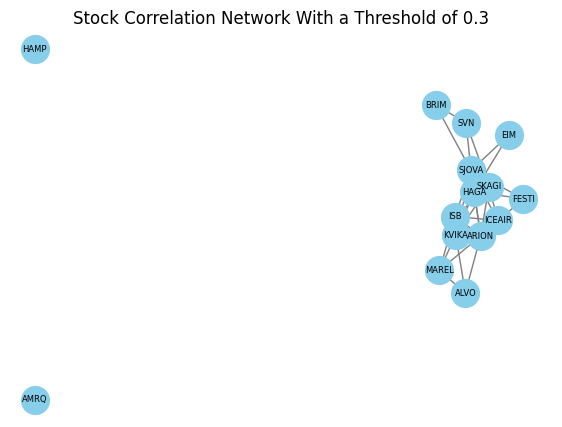

In [18]:
# Get the adjacency matrix

threshold = 0.3
adj_matrix = get_adjacency_matrix(train.drop('OMXI15', axis=1), threshold)

# Make an adjacency graph using NetworkX 
G = nx.from_numpy_array(adj_matrix)

# Create a mapping from index to ticker
tickers = df.columns.tolist()
index_to_ticker = {index: ticker for index, ticker in enumerate(tickers)}

# Relabel nodes
G = nx.relabel_nodes(G, index_to_ticker)

# Draw the graph with tickers as labels
plt.figure(figsize=(7, 5))
plt.title(f'Stock Correlation Network With a Threshold of {threshold}')
nx.draw(G, with_labels=True, node_size=400, node_color='skyblue', font_size=6, edge_color='gray')
plt.show()



# PART 1: Constructing Replicating Portfolios

### There is a core group of highly intercorrelated stocks in the center of the network. Lets assess them using different centrality measures.
#### - **Degree Centrality:** The fraction of nodes a node $v$ is connected to. So, the higher the degree, the more central the node is.
#### - **Closeness Centrality:** The closeness centrality of a node measures its average farness to all other reachable nodes.
#### - **Betweeness Centrality:** Betweenness centrality measures the extent to which a vertex lies on paths between other vertices. Vertices with high betweenness may have considerable influence within a network by virtue of their control over information passing between others.

In [19]:
# Find the centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Find the top 5 stocks for each centrality measure
top_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

top_5_degree = [x[0] for x in top_5_degree]
top_5_closeness = [x[0] for x in top_5_closeness]
top_5_betweenness = [x[0] for x in top_5_betweenness]

# Print the top 5 stocks for each centrality measure
print('Top 5 Stocks by Degree Centrality:')
print(top_5_degree)
print('\nTop 5 Stocks by Closeness Centrality:')
print(top_5_closeness)
print('\nTop 5 Stocks by Betweenness Centrality:')
print(top_5_betweenness)

Top 5 Stocks by Degree Centrality:
['ARION', 'SJOVA', 'KVIKA', 'ISB', 'SKAGI']

Top 5 Stocks by Closeness Centrality:
['ARION', 'SJOVA', 'KVIKA', 'ISB', 'SKAGI']

Top 5 Stocks by Betweenness Centrality:
['SJOVA', 'ARION', 'KVIKA', 'SKAGI', 'HAGA']


### Since the degree centrality portfolio and the closeness centrality portfolio are the same, we will henceforth just look at the degree centrality portfolio. 
### Using the top 5 stocks by centrality measures, we can try to construct replicating portfolios. We will use least squares regression to optimize the weights needed to <ins>minimize the difference between the index and the stocks.

In [20]:
# Function to fit model and return weights
def fit_model_and_get_weights(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

# Centrality types and their corresponding top 5 stocks
centrality_types = {
    'degree': top_5_degree,
    'betweenness': top_5_betweenness
}

# Dependent variable: Index return
y = train['OMXI15']

# Dictionary to hold the weights for each centrality measure
weights = {}

# Loop through each centrality type, fit model, and store weights
for centrality, stocks in centrality_types.items():
    X = train[stocks]
    weights[centrality] = fit_model_and_get_weights(X, y)
    print(f"Weights of the stocks in the {centrality} centrality portfolio:", weights[centrality])

Weights of the stocks in the degree centrality portfolio: [0.30383005 0.15906668 0.20933715 0.22847364 0.03269786]
Weights of the stocks in the betweenness centrality portfolio: [0.18069647 0.33941628 0.2466583  0.03642254 0.11285968]


### Lets now construct the new portfolios and add them to our train dataframe

In [21]:
# Add new portfolios to the dataframe based on the centrality measures
train['Degree Centrality Portfolio'] = train[top_5_degree[0]] * weights['degree'][0] + \
                                      train[top_5_degree[1]] * weights['degree'][1] + \
                                      train[top_5_degree[2]] * weights['degree'][2] + \
                                      train[top_5_degree[3]] * weights['degree'][3] + \
                                      train[top_5_degree[4]] * weights['degree'][4]

train['Betweenness Centrality Portfolio'] = train[top_5_betweenness[0]] * weights['betweenness'][0] + \
                                            train[top_5_betweenness[1]] * weights['betweenness'][1] + \
                                            train[top_5_betweenness[2]] * weights['betweenness'][2] + \
                                            train[top_5_betweenness[3]] * weights['betweenness'][3] + \
                                            train[top_5_betweenness[4]] * weights['betweenness'][4]                       

train


,ALVO,AMRQ,ARION,BRIM,EIM,FESTI,HAGA,HAMP,ICEAIR,ISB,KVIKA,MAREL,SJOVA,SKAGI,SVN,OMXI15,Degree Centrality Portfolio,Betweenness Centrality Portfolio
Date,,,,,,,,,,,,,,,,,,
2023-01-03,0.013514,0.012579,0.003361,-0.005540,0.009662,0.005450,-0.006969,0.000000,0.023811,0.000000,0.002608,0.030521,0.002999,0.017805,0.008163,0.010443,0.002626,0.002188
2023-01-04,-0.013514,0.018576,-0.003361,0.005540,0.019048,0.000000,0.006969,-0.017094,-0.002356,0.005029,0.000000,0.013931,0.011905,0.017493,0.000000,0.005379,0.002593,0.002434
2023-01-05,0.006780,0.006116,-0.003373,0.000000,0.000000,-0.005450,-0.013986,0.021829,0.019849,-0.006711,0.000000,0.007874,-0.005935,-0.011628,-0.008163,0.000757,-0.003882,-0.004219
2023-01-06,0.096538,-0.006116,0.026668,-0.003875,0.000000,0.010870,0.007018,-0.013245,-0.025763,0.010050,0.005195,0.023257,0.002972,0.002920,0.004090,0.013166,0.012054,0.011768
2023-01-09,0.090838,0.000000,-0.006601,0.003875,0.009390,0.000000,0.010435,0.025318,0.002370,-0.011735,0.015424,0.018976,-0.002972,-0.002920,0.012171,0.004483,-0.002026,0.002099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.012862,0.013015,0.003407,0.007417,0.027170,0.012903,0.047467,0.045120,0.000000,-0.008969,0.030867,0.014753,0.007566,0.021117,0.023867,0.012502,0.007342,0.016263
2023-12-22,-0.009631,0.004301,-0.010257,-0.007417,-0.006205,0.020305,0.000000,-0.014815,0.018485,0.004494,0.006061,-0.004193,-0.017744,-0.002990,-0.007101,-0.000563,-0.003741,-0.005302
2023-12-27,0.000000,0.000000,0.003431,0.014779,0.010320,0.019901,0.032576,0.029414,-0.018485,0.008929,0.020928,0.004193,0.015229,0.000000,0.007101,0.005849,0.009886,0.012755


### Now we can plot how 100 USD invested in each portfolio and the index would have performed for the training period

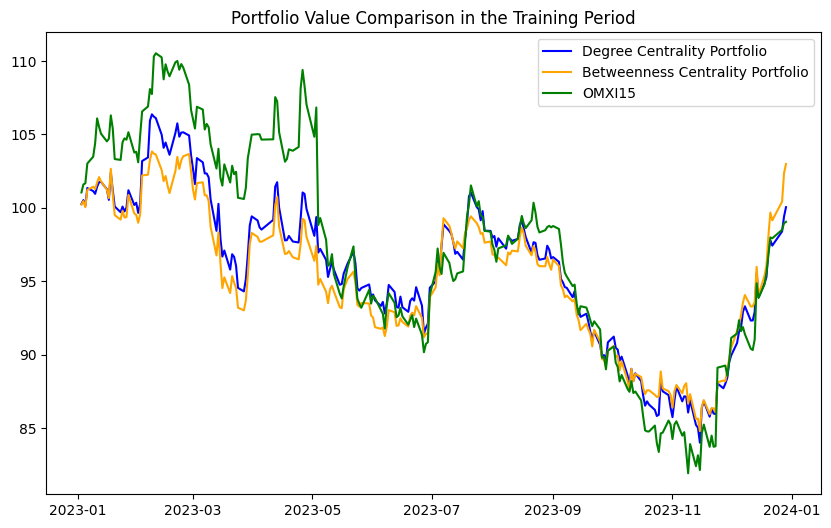

Correlation between Degree Centrality Portfolio VALUES and OMXI15 VALUES in the training period:
0.9588694443200079
Correlation between Betweenness Centrality Portfolio VALUES and OMXI15 VALUES in the training period:
0.9298126735711719

Correlation between Degree Centrality Portfolio RETURNS and OMXI15 RETURNS in the training period:
0.7983021560142639
Correlation between Betweenness Centrality Portfolio RETURNS and OMXI15 RETURNS in the training period:
0.7727716449564517


In [22]:
# Now lets see how 100 USD invested in each portfolio would have performed
investment = 100
train['Degree Centrality Portfolio Value'] = investment * np.exp(train['Degree Centrality Portfolio'].cumsum())
train['Betweenness Centrality Portfolio Value'] = investment * np.exp(train['Betweenness Centrality Portfolio'].cumsum())
train['OMXI15 Value'] = investment * np.exp(train['OMXI15'].cumsum())

# Plot the portfolio values
plt.figure(figsize=(10, 6))
plt.title('Portfolio Value Comparison in the Training Period')
plt.plot(train['Degree Centrality Portfolio Value'], label='Degree Centrality Portfolio', color='blue')
plt.plot(train['Betweenness Centrality Portfolio Value'], label='Betweenness Centrality Portfolio', color='orange')
plt.plot(train['OMXI15 Value'], label='OMXI15', color='green')
plt.legend()
plt.show()

print('Correlation between Degree Centrality Portfolio VALUES and OMXI15 VALUES in the training period:')
print(np.corrcoef(train['Degree Centrality Portfolio Value'], train['OMXI15 Value'])[0, 1])
print('Correlation between Betweenness Centrality Portfolio VALUES and OMXI15 VALUES in the training period:')
print(np.corrcoef(train['Betweenness Centrality Portfolio Value'], train['OMXI15 Value'])[0, 1])
print()
print('Correlation between Degree Centrality Portfolio RETURNS and OMXI15 RETURNS in the training period:')
print(np.corrcoef(train['Degree Centrality Portfolio'], train['OMXI15'])[0, 1])
print('Correlation between Betweenness Centrality Portfolio RETURNS and OMXI15 RETURNS in the training period:')
print(np.corrcoef(train['Betweenness Centrality Portfolio'], train['OMXI15'])[0, 1])

### The replicating portfolios, Degree centrality and Betweeness centrality, are able to follow the OMXI15 index fairly well, with correlation coefficients on returns of ~0.80 and ~0.77 respectively. Lets add the testing data to the series to validate the out of sample performance.

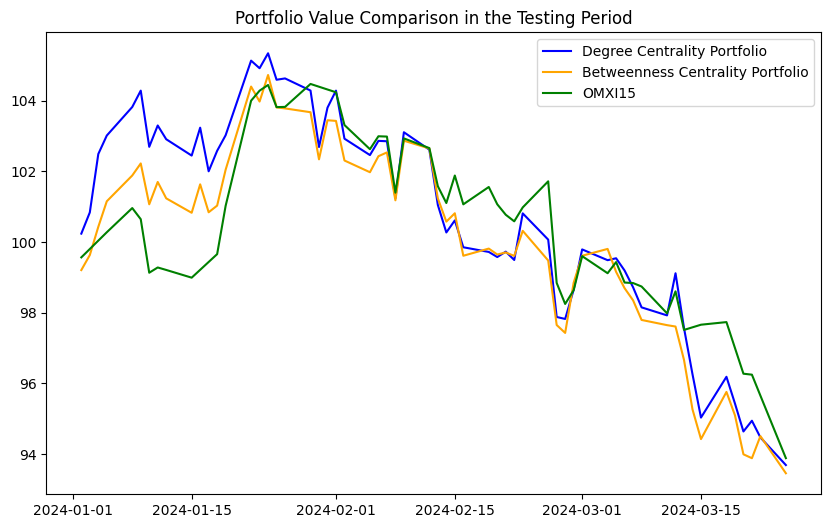

Correlation between Degree Centrality Portfolio VALUES and OMXI15 VALUES in the testing period:
0.8355297812725825
Correlation between Betweenness Centrality Portfolio VALUES and OMXI15 VALUES in the testing period:
0.9024655103945399

Correlation between Degree Centrality Portfolio RETURNS and OMXI15 RETURNS in the testing period:
0.7347721685475836
Correlation between Betweenness Centrality Portfolio RETURNS and OMXI15 RETURNS in the testing period:
0.7373683507422143


In [23]:
# Add new portfolios to the testing dataframe based on the centrality measures
test['Degree Centrality Portfolio'] = test[top_5_degree[0]] * weights['degree'][0] + \
                                      test[top_5_degree[1]] * weights['degree'][1] + \
                                      test[top_5_degree[2]] * weights['degree'][2] + \
                                      test[top_5_degree[3]] * weights['degree'][3] + \
                                      test[top_5_degree[4]] * weights['degree'][4]

test['Betweenness Centrality Portfolio'] = test[top_5_betweenness[0]] * weights['betweenness'][0] + \
                                            test[top_5_betweenness[1]] * weights['betweenness'][1] + \
                                            test[top_5_betweenness[2]] * weights['betweenness'][2] + \
                                            test[top_5_betweenness[3]] * weights['betweenness'][3] + \
                                            test[top_5_betweenness[4]] * weights['betweenness'][4]                       

# Now lets see how 100 USD invested in each portfolio would have performed in the test set
investment = 100
test['Degree Centrality Portfolio Value'] = investment * np.exp(test['Degree Centrality Portfolio'].cumsum())
test['Betweenness Centrality Portfolio Value'] = investment * np.exp(test['Betweenness Centrality Portfolio'].cumsum())
test['OMXI15 Value'] = investment * np.exp(test['OMXI15'].cumsum())

# Plot the portfolio values
plt.figure(figsize=(10, 6))
plt.title('Portfolio Value Comparison in the Testing Period')
plt.plot(test['Degree Centrality Portfolio Value'], label='Degree Centrality Portfolio' ,color='blue')
plt.plot(test['Betweenness Centrality Portfolio Value'], label='Betweenness Centrality Portfolio',color='orange')
plt.plot(test['OMXI15 Value'].interpolate(), label='OMXI15', color='green') # <-- Interpolating the test data since it has some NaN values
plt.legend(loc='upper right')
plt.show()


print('Correlation between Degree Centrality Portfolio VALUES and OMXI15 VALUES in the testing period:')
print(np.corrcoef(test['Degree Centrality Portfolio Value'], test['OMXI15 Value'].interpolate())[0, 1])
print('Correlation between Betweenness Centrality Portfolio VALUES and OMXI15 VALUES in the testing period:')
print(np.corrcoef(test['Betweenness Centrality Portfolio Value'], test['OMXI15 Value'].interpolate())[0, 1])
print()
print('Correlation between Degree Centrality Portfolio RETURNS and OMXI15 RETURNS in the testing period:')
print(np.corrcoef(test['Degree Centrality Portfolio'], test['OMXI15'].interpolate())[0, 1])
print('Correlation between Betweenness Centrality Portfolio RETURNS and OMXI15 RETURNS in the testing period:')
print(np.corrcoef(test['Betweenness Centrality Portfolio'], test['OMXI15'].interpolate())[0, 1])


## Conclusion:
### Our method prooves to be relatively good at replicating the index. However, it is worth mentioning that the OMXI15 index is a weighted index and it includes the pharmaceutical company ALVOTECH which is disproportionately larger than the other constituents and brings a lot of volatility. Our replicating portfolios did not include this ticker and therefore struggle to catch the jumps in the index that are caused by it. This results in lower return correlations even though directional correlation is high. 

# PART 2: Constructing Robust Portfolios

### We have looked at constructing replicating portfolios through highly intercorrelated stocks. Lets now turn to constructing some robust portfolios of lower correlated assets. We use the same metrics for assessing centrality but now we make portfolios of the bottom 5 stocks in each centrality measure.

In [24]:
# Find the bottom 5 stocks for each centrality measure
bottom_5_degree = sorted(degree_centrality.items(), key=lambda x: x[1])[:5]
bottom_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1])[:5]
bottom_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1])[:5]

bottom_5_degree = [x[0] for x in bottom_5_degree]
bottom_5_closeness = [x[0] for x in bottom_5_closeness]
bottom_5_betweenness = [x[0] for x in bottom_5_betweenness]

# Print the bottom 5 stocks for each centrality measure
print('Bottom 5 Stocks by Degree Centrality:')
print(bottom_5_degree)
print('\nBottom 5 Stocks by Closeness Centrality:')
print(bottom_5_closeness)
print('\nBottom 5 Stocks by Betweenness Centrality:')
print(bottom_5_betweenness)

Bottom 5 Stocks by Degree Centrality:
['AMRQ', 'HAMP', 'BRIM', 'EIM', 'ALVO']

Bottom 5 Stocks by Closeness Centrality:
['AMRQ', 'HAMP', 'BRIM', 'ALVO', 'EIM']

Bottom 5 Stocks by Betweenness Centrality:
['ALVO', 'AMRQ', 'BRIM', 'HAMP', 'ICEAIR']


### As was the case in PART 1, the Degree centrality and Closeness Centrality portfolios are the same. So we will only construct the Degree centrality portfolio and the Betweenness Centrality portfolio. 
### Using the bottom 5 stocks by centrality measures, we can construct robust portfolios. We will optimize the weights to <ins>maximize the sharpe ratio.

In [25]:
# Make new copies of the training and testing data
train = df.loc[train_start:train_end].copy()
test = df.loc[test_start:].copy()

# Centrality types and their corresponding top 5 stocks
centrality_types = {
    'degree': bottom_5_degree,
    'betweenness': bottom_5_betweenness
}

def sharpe_maximization(df, stocks):
    df = df[stocks]
    # Calculate the expected returns
    expected_returns = df.mean()
    # Calculate the covariance matrix
    covariance_matrix = df.cov()
    # Define the number of stocks
    n_stocks = len(expected_returns)

    # Sharpe Ratio optimization function
    def neg_sharpe_ratio(weights, expected_returns, covariance_matrix, risk_free_rate):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # Negative for minimization

    # Constraints and bounds
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(n_stocks))

    # Initial guess
    initial_guess = np.array(n_stocks * [1. / n_stocks])

    # Optimization
    opt_results = minimize(neg_sharpe_ratio, initial_guess, args=(expected_returns, covariance_matrix, 0), method='SLSQP', bounds=bounds, constraints=constraints)

    # Optimal weights
    optimal_weights = opt_results.x

    return optimal_weights

weights_ = {}

for centrality, stocks in centrality_types.items():
    optimal_weights = sharpe_maximization(train, stocks)
    formatted_weights = ", ".join(f"{weight:.8}" for weight in optimal_weights)
    print(f'Optimal weights for the {centrality} centrality portfolio: [{formatted_weights}]')
    weights_[centrality] = optimal_weights



Optimal weights for the degree centrality portfolio: [0.76908811, 0.23091189, 0.0, 2.2334565e-17, 0.0]
Optimal weights for the betweenness centrality portfolio: [4.2140895e-18, 0.76827122, 0.0, 0.23172878, 5.0859833e-17]


### Optimizing the Sharpe ratios of the portfolios reveals weights of zero on all the tickers in the symmetric difference. So the Maximum Sharpe-Ratio Degree Centrality portfolio is the same as the Maximum Sharpe-Ratio Betweenness Centrality portfolio. So, from here we only look at the Maximum Sharpe-Ratio Degree Centrality portfolio. Lets construct it

In [26]:
train['Degree Centrality Portfolio'] = train[bottom_5_degree[0]] * weights_['degree'][0] + \
                                      train[bottom_5_degree[1]] * weights_['degree'][1] + \
                                      train[bottom_5_degree[2]] * weights_['degree'][2] + \
                                      train[bottom_5_degree[3]] * weights_['degree'][3] + \
                                      train[bottom_5_degree[4]] * weights_['degree'][4]

### Now we can plot how 100 USD invested in the portfolio and the index would have performed for the training period

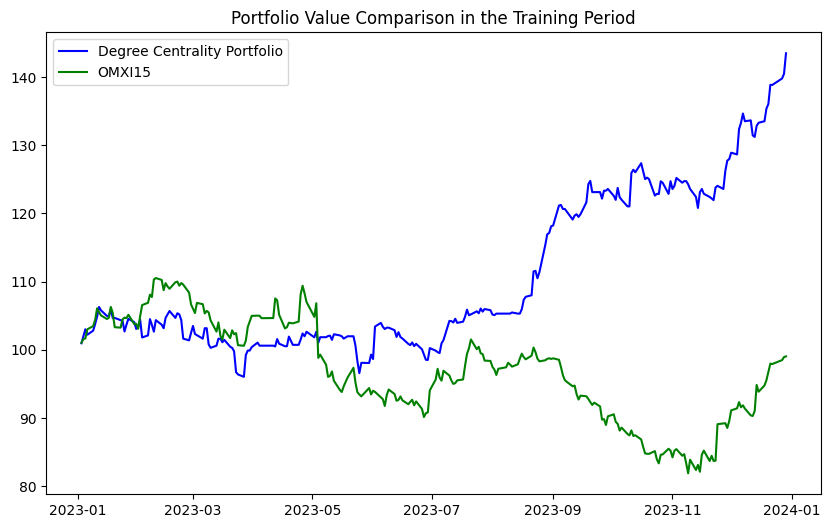

Degree Centrality Portfolio:
Volatility: 0.010527849111496472
Average Drawdown: 0.026576620666119627

OMXI15:
Volatility: 0.01253905594266747
Average Drawdown: 0.1180592180335021


In [27]:
# Now lets see how 100 USD invested in the portfolio and the index would have performed
investment = 100
train['Degree Centrality Portfolio Value'] = investment * np.exp(train['Degree Centrality Portfolio'].cumsum())
train['OMXI15 Value'] = investment * np.exp(train['OMXI15'].cumsum())

# Plot the portfolio values
plt.figure(figsize=(10, 6))
plt.title('Portfolio Value Comparison in the Training Period')
plt.plot(train['Degree Centrality Portfolio Value'], label='Degree Centrality Portfolio', color='blue')
plt.plot(train['OMXI15 Value'], label='OMXI15', color='green')
plt.legend()
plt.show()

# Calculate the volatility and average drawdown of the portfolios
def average_drawdown(returns):
    cum_returns = np.exp(returns.cumsum())
    running_max = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - running_max) / running_max
    return abs(np.mean(drawdown))

print('Degree Centrality Portfolio:')
print('Volatility:', train['Degree Centrality Portfolio'].std())
print('Average Drawdown:', average_drawdown(train['Degree Centrality Portfolio']))
print()
print('OMXI15:')
print('Volatility:', train['OMXI15'].std())
print('Average Drawdown:', average_drawdown(train['OMXI15']))

### The robust portfolio shows very promising performance, beating the OMXI15 index by a significant margin in the testing period. Lets add the testing data to the series to validate the out of sample performance.

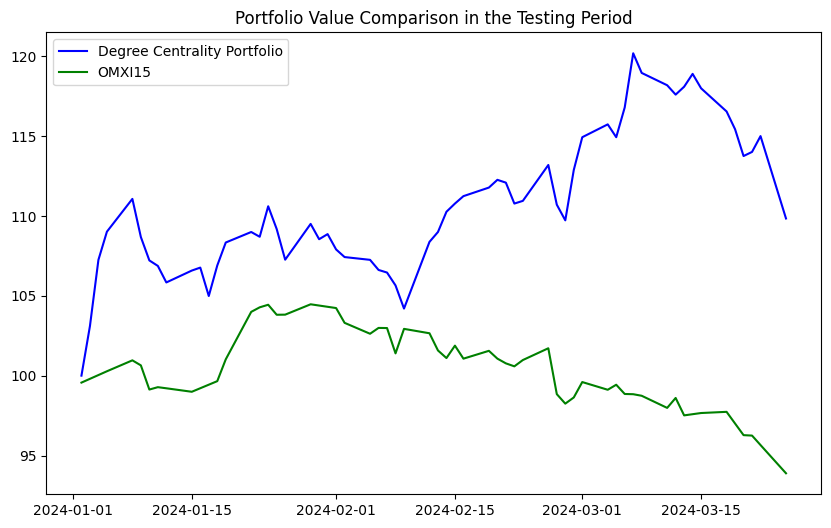

Degree Centrality Portfolio:
Volatility: 0.01564363206466246
Average Drawdown: 0.02195956163412684

OMXI15:
Volatility: 0.00907973166344345
Average Drawdown: 0.0


In [28]:
test['Degree Centrality Portfolio'] = test[bottom_5_degree[0]] * weights_['degree'][0] + \
                                      test[bottom_5_degree[1]] * weights_['degree'][1] + \
                                      test[bottom_5_degree[2]] * weights_['degree'][2] + \
                                      test[bottom_5_degree[3]] * weights_['degree'][3] + \
                                      test[bottom_5_degree[4]] * weights_['degree'][4]

# Now lets see how 100 USD invested in the portfolio and the index would have performed out of sample
investment = 100
test['Degree Centrality Portfolio Value'] = investment * np.exp(test['Degree Centrality Portfolio'].cumsum())
test['OMXI15 Value'] = investment * np.exp(test['OMXI15'].cumsum())

# Plot the portfolio values
plt.figure(figsize=(10, 6))
plt.title('Portfolio Value Comparison in the Testing Period')
plt.plot(test['Degree Centrality Portfolio Value'], label='Degree Centrality Portfolio', color='blue')
plt.plot(test['OMXI15 Value'].interpolate(), label='OMXI15', color='green')
plt.legend()
plt.show()

# Calculate the volatility and average drawdown of the portfolios
print('Degree Centrality Portfolio:')
print('Volatility:', test['Degree Centrality Portfolio'].std())
print('Average Drawdown:', average_drawdown(test['Degree Centrality Portfolio']))
print()
print('OMXI15:')
print('Volatility:', test['OMXI15'].std())
print('Average Drawdown:', average_drawdown(test['OMXI15']))


## Conclusion
### Constructing robust portfolios based on lowest degree centralities in an adjacency graph of stocks seems to work rather poorly in our example as the portfolio carries more volatility than that of the index in the testing period. Probably because of the fact that it only consists of two stocks and thus could be more diversified. Further research is warranted as this methodology probably works better on indeces that are comprised of more and less correlated stocks.